In [31]:
import numpy as np
from skimage.transform import resize
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D, ConvLSTM2D, TimeDistributed
from sklearn.externals import joblib
import pylidc as pl
import pydot

from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline

In [32]:
image_size = (256, 256)
num_slices = 50

In [33]:
model = Sequential()
model.add(ConvLSTM2D(filters=20, kernel_size=(3, 3), input_shape=(num_slices, *image_size, 1),
                     padding='same', return_sequences=True))
model.add(TimeDistributed(Conv2D(1, 1, activation='sigmoid')))
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
#from keras.utils import plot_model
#plot_model(model, to_file='lstm_model.png')

In [34]:
unet = load_model('unet.hdf5')
lstm = load_model('unet_lstm.hdf5')

In [35]:
scans = pl.query(pl.Scan)
n = scans.count()

In [36]:
test = joblib.load('test_set.p')
train = list(set(range(n)) - set(test))

In [37]:
def get_data(i, only_nodules=True):
    scan = scans[i]
    images = scan.load_all_dicom_images(verbose=False)
    n = len(images)
    X = np.array([resize(im.pixel_array, image_size, mode='constant') for im in images])
    X = np.expand_dims(X, axis=-1)
    y = np.zeros((512, 512, n))
    for ann in scan.annotations:
        b = ann.bbox()
        y[b] = np.logical_or(y[b], ann.boolean_mask())
    y = np.rollaxis(y, 2, 0)
    y = resize(y, (n, *image_size), mode='constant')
    y = np.expand_dims(y, axis=-1)
    start = np.random.randint(n - num_slices)
    X = X[start:start + num_slices]
    y = y[start:start + num_slices]
    y = np.expand_dims(y, axis=-1)
    return unet.predict(X, batch_size=1)[None], y[None]

In [38]:
num_epochs = 2
num_samples = 200

In [30]:
for _ in range(num_samples):
    while True:
        i = np.random.choice(train)
        print(i)
        try:
            X, y = get_data(i)
            lstm.fit(X, y, batch_size=1, epochs=num_epochs)
            lstm.save('unet_lstm.hdf5')
            break
        except OSError:
            print('Problem getting data')

329


ValueError: Error when checking target: expected time_distributed_1 to have 5 dimensions, but got array with shape (1, 50, 256, 256, 1, 1)

In [ ]:
#model.save('unet_lstm.hdf5')

In [15]:
# evaluate lstm
X, y = get_data(np.random.choice(test))
preds = model.predict(X, batch_size=1)
fpr, tpr, _ = roc_curve(np.rint(y).flatten(), preds.flatten())

In [21]:
X_unet = X.reshape((-1, *image_size, 1))
y_unet = y.reshape((-1, *image_size, 1))

In [22]:
preds_unet = unet.predict(X_unet, batch_size=1)
fpr_unet, tpr_unet, _ = roc_curve(np.rint(y_unet).flatten(), preds_unet.flatten())

In [23]:
print(auc(fpr, tpr))
print(auc(fpr_unet, tpr_unet))

0.9732168007531221
0.7169184511734369


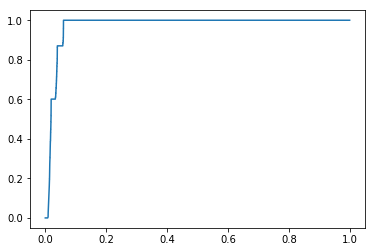

In [17]:
plt.plot(fpr, tpr)

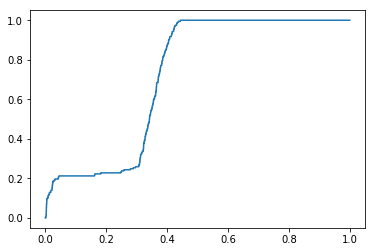

In [24]:
plt.plot(fpr_unet, tpr_unet)